In [1]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy

import utils
import som

In [2]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:02<00:00, 6697.41it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [3]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [4]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'banana', 'fruity', 'cherry', 'pineapple', 'tropical', 'sweet'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [5]:
def do_train(config,verbose=False):
    shape = (config["width"], config["height"], len(all_notes_list))
    map = som.SOM(shape=shape,
              wrapping=som.WrappingMode.SPHERICAL,
              gauss=config["gauss"],
              decay=config["decay"],
              use_onehot=config["onehot"],
              clip_models=config["clip"],
              use_tanh=config["tanh"])

    encodings = torch.stack([mol["encoding"] for mol in molecules])

    # steps = int(config["width"] * config["height"])
    # steps = config["width"], config["height"]
    steps = int((config["width"] * config["height"]))
    for i in tqdm.tqdm(range(steps),smoothing=0, disable=not verbose):
        map.update_batch(encodings)
        map.do_decay()

    print(map.gauss)
    return map

mapw = 15
maph = 12
step = .05

# In general, the larger the initial gauss, the longer the training will have to be
# Though using a stronger decay reduces this.
# A larger initial gauss does tend to lead to better distributions, though.

all_models = []
all_params = []
for clip in [True,False]:
    for tanh in [True,False]:
        params = {'width': mapw, 'height': maph, "gauss":min(mapw,maph)/2, "decay": .9, "onehot": True, "clip": clip, "tanh":tanh}
        all_models.append(do_train(params,verbose=True))
        all_params.append(params)
        


100%|█████████████████████████████████████████| 180/180 [01:05<00:00,  2.73it/s]


0.6000000000000001


100%|█████████████████████████████████████████| 180/180 [01:01<00:00,  2.93it/s]


0.6000000000000001


100%|█████████████████████████████████████████| 180/180 [01:05<00:00,  2.73it/s]


0.6000000000000001


100%|█████████████████████████████████████████| 180/180 [01:02<00:00,  2.89it/s]

0.6000000000000001


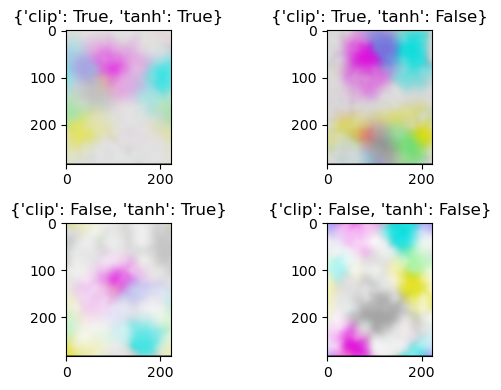

In [6]:
import PIL

def to_img_array(map,encoding,step,invert,thresh=0):
    _, rsz_actvn, rsz_shape = map.get_interpolated_activations(encoding,step,method="cubic")
    mtrx = torch.nn.functional.threshold(rsz_actvn,thresh,0).reshape(*rsz_shape).numpy()
    if invert:
        mtrx = 1-mtrx
    mtrx_norm = mtrx*255
    
    return clean(mtrx_norm)

def add_border(pil_img, border):
    width, height = pil_img.size
    new_width = width + 2*border
    new_height = height + 2*border
    result = PIL.Image.new(pil_img.mode, (new_width, new_height), 0)
    result.paste(pil_img, (border, border))
    return result

def clean(img_array):
    assert img_array.min() >= 0 and img_array.max() <= 255
    return img_array.astype('uint8')
    

def make_bw_pil(img_array, border=0):
    assert img_array.dtype=="uint8"
    assert img_array.min() >= 0 and img_array.max() <= 255
    w,h = img_array.shape
    img = PIL.Image.fromarray(img_array,mode="L")
    return add_border(img,border)

def make_rgb_pil(img_array,border=0):
    assert img_array.dtype=="uint8"
    assert img_array.min() >= 0 and img_array.max() <= 255
    w,h,c = img_array.shape
    assert c == 3
    img = PIL.Image.fromarray(img_array,mode="RGB")
    return add_border(img,border)

rgb_imgs = []
for map in all_models:
    all_imgs = []
    for n,f in all_notes.most_common(3):
        bmu = map.get_bmu(multi_hot([n]))
        imgar = to_img_array(map,multi_hot([n]),step=step,invert=True,thresh=0)
        all_imgs.append(imgar)
    rgb_imgs.append(np.stack(all_imgs,axis=-1))

def to_title(params):
    return {"clip":params["clip"],"tanh":params["tanh"]}

fig, axs = plt.subplots(2, 2,figsize=(6,4))
for i in range(len(all_models)):
    x = int(i/2)
    y = i%2
    axs[x,y].imshow(make_rgb_pil(rgb_imgs[i],1))
    axs[x,y].set_title(to_title(all_params[i]))
plt.tight_layout()
plt.show()

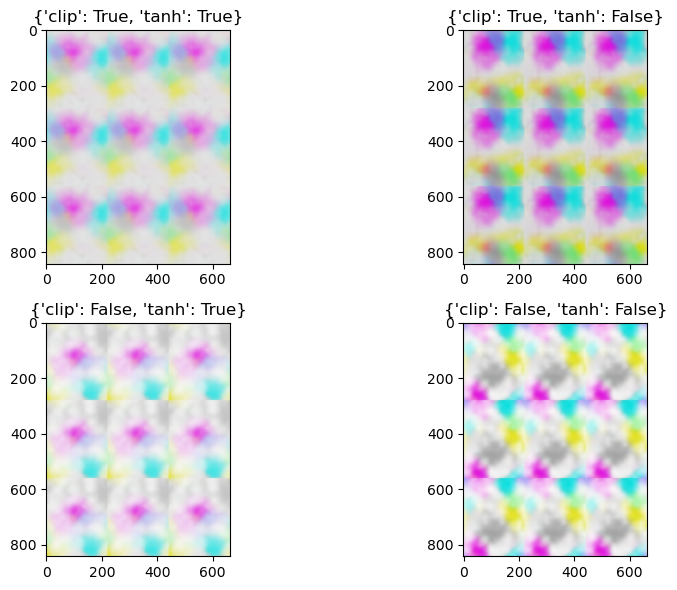

In [7]:
# Attempting to tile the np arrays causes the border to be too thick.
def tile_pil(pil_img,tile_w,tile_h):
    w,h = pil_img.width, pil_img.height
    dst = PIL.Image.new(pil_img.mode, (w*tile_w, h*tile_h))
    for x in range(tile_w):
        for y in range(tile_h):
            dst.paste(pil_img,(x*w,y*h))
    return dst

fig, axs = plt.subplots(2, 2,figsize=(10,6))
for i in range(len(all_models)):
    x = int(i/2)
    y = i%2
    axs[x,y].imshow(tile_pil(make_rgb_pil(rgb_imgs[i],0),3,3))
    axs[x,y].set_title(to_title(all_params[i]))
plt.tight_layout()
plt.show()

In [10]:
palette = ["EF476F","FFD166","06D6A0","118AB2"]

def draw_square(color):
    display(PIL.Image.new("RGB", (20, 20), color))

# Roughly the center
color_array = []
for i,color in enumerate(palette):
    rgb_color = PIL.ImageColor.getrgb(f"#{color}")
    color_array.append(rgb_color)
    draw_square(rgb_color)

color_array = np.stack(color_array)

all_layers = []
for map in tqdm.tqdm(all_models):
    layers = []
    for n,f in all_notes.most_common(4):
        layers.append(to_img_array(map,multi_hot([n]),step=step,invert=False))
    layers = np.stack(layers,axis=-1)
    all_layers.append(layers)

100%|█████████████████████████████████████████████| 4/4 [00:38<00:00,  9.51s/it]


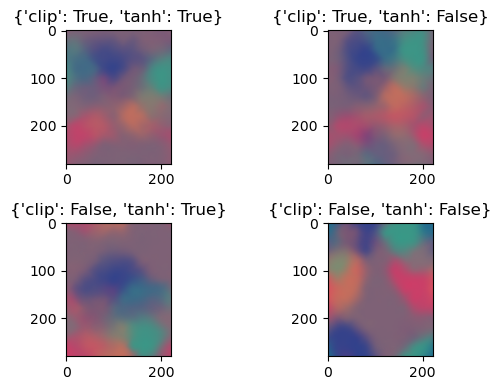

In [11]:
fig, axs = plt.subplots(2, 2,figsize=(6,4))
for i,layers in enumerate(all_layers):
    layer_weights = layers.astype(float)/255
    layer_color = np.matmul(layer_weights,color_array) / (layer_weights.sum(axis=-1,keepdims=True))
    layer_color = np.nan_to_num(layer_color,0)
    layer_color = clean(layer_color)

    x = int(i/2)
    y = i%2
    axs[x,y].imshow(make_rgb_pil(255-layer_color))
    axs[x,y].set_title(to_title(all_params[i]))
plt.tight_layout()
plt.show()

0.0 189.6
0.0 189.6
0.0 189.6
0.0 189.6


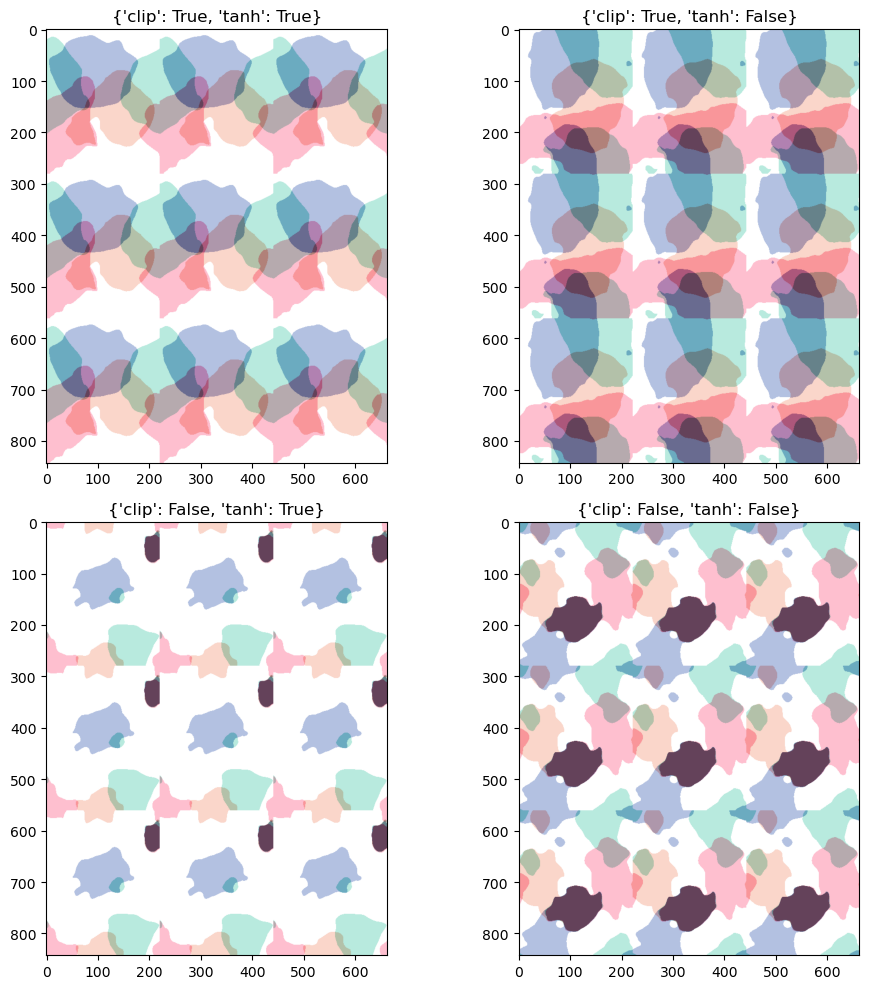

In [12]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
for i,layers in enumerate(all_layers):
    layer_weights = layers.astype(float)/255
    threshed_weights = np.where(layer_weights > .2, .3, 0)
    with np.errstate(divide='ignore', invalid='ignore'):
        layer_color = np.matmul(threshed_weights,color_array)
    # break
    layer_color = np.nan_to_num(layer_color,0,posinf=0,neginf=0)
    print(layer_color.min(),layer_color.max())
    # layer_color = np.clip(layer_color, a_min=0, a_max=255)
    layer_color = clean(layer_color)

    x = int(i/2)
    y = i%2
    axs[x,y].imshow(tile_pil(make_rgb_pil(255-layer_color),3,3))
    axs[x,y].set_title(to_title(all_params[i]))
plt.tight_layout()
plt.show()

0.0 170.478431372549
0.0 250.93333333333334
0.0 142.10980392156864
0.0 221.39999999999998


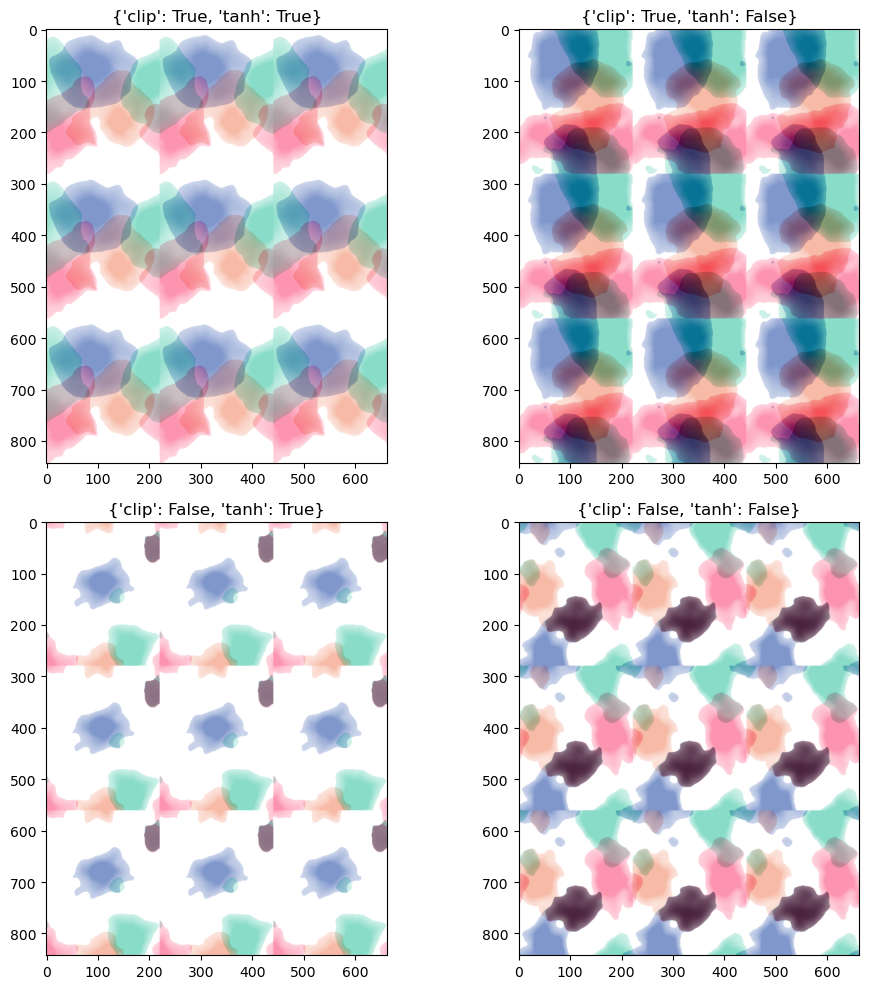

In [13]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
for i,layers in enumerate(all_layers):
    layer_weights = layers.astype(float)/255
    threshed_weights = np.where(layer_weights > .2, np.clip(layer_weights, a_min=0,a_max=.5), 0)
    with np.errstate(divide='ignore', invalid='ignore'):
        layer_color = np.matmul(threshed_weights,color_array)
    # break
    layer_color = np.nan_to_num(layer_color,0,posinf=0,neginf=0)
    print(layer_color.min(),layer_color.max())
    # layer_color = np.clip(layer_color, a_min=0, a_max=255)
    layer_color = clean(layer_color)

    x = int(i/2)
    y = i%2
    axs[x,y].imshow(tile_pil(make_rgb_pil(255-layer_color),3,3))
    axs[x,y].set_title(to_title(all_params[i]))
plt.tight_layout()
plt.show()